In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# add the path to my packages to system paths so they can be imported
import sys
# sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import my_first_feature_extractor as fe
import compare_with_benchmark as bn
import my_similarity_graph_eff_test as sg

# Load spike data

In [2]:
# load all spike data from file
data_path = '../../data/original_files/'
binned_data = np.loadtxt(data_path + 'spikes.csv', delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

In [3]:
# print some statistics
print('binned_data.shape = ', binned_data.shape)

avg_spike_perc = 0
print('neuron #    | percentage belonging to class 1')
print('---------------------------------------------')
for neu_i in I_order_10:
    pers = fe.class_percentages(binned_data[0,:,neu_i], [0, 1])
    avg_spike_perc += pers[1]
    print('neuron #{:3} | {:.2f}%'.format(neu_i, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f}% of data belongs to class 1'.format(avg_spike_perc))

binned_data.shape =  (297, 1141, 113)
neuron #    | percentage belonging to class 1
---------------------------------------------
neuron # 54 | 1.84%
neuron # 35 | 2.63%
neuron # 10 | 2.28%
neuron # 60 | 1.58%
neuron # 74 | 1.93%
neuron #  9 | 0.44%
neuron # 61 | 3.24%
neuron # 56 | 1.14%
neuron # 91 | 5.78%
neuron #104 | 2.10%
---------------------------------------------
AVERAGE     | 2.30% of data belongs to class 1


# Load feature vectors

In [4]:
def get_data(train_num, val_num, max_sz, labels, path, seed=None):
    """
    Create a dict of feature vectors and their corresponding labels.
    Feature vectors are loaded from a path and labels are given as an input.
    Data points are selected randomly.
    
    Input: train_num, val_num, max_sz, labels, path, seed
    train_num - size of training dataset to be returned
    val_num - size of validation dataset to be returned
    max_sz - maximum possible size of dataset (number of all available feature vectors)
    labels - original spike data
    path - path to where feature vectors are stored
    seed - for random selection of data points (default: None)
    
    Output: train_num, val_num, train_data, val_data
    train_num - number of training data points
    val_num - number of validation data points
    train_data - 
        des - NxD numpy array of feature vectors
        lbls - Nx1 numpy array of corresponding labels
        samples - list of indices of chosen feature vectors
    val_data - 
        des - NxD numpy array of feature vectors
        lbls - Nx1 numpy array of corresponding labels
        samples - list of indices of chosen feature vectors
    """
    train_num = min(train_num, max_sz)
    val_num = min(val_num, max_sz-train_num)
    
    # create a list of indices of chosen feature vectors
    rng = np.random.default_rng(seed)
    samples = rng.choice(max_sz, size=(train_num+val_num), replace=False)
    train_smpls = samples[:train_num]
    val_smpls = samples[train_num:]
    
    train_des = [torch.load(path+'fv_'+str(i)+'.pt') for i in train_smpls]
    train_des = torch.cat(train_des)
    train_des = train_des.detach().numpy()
    val_des = [torch.load(path+'fv_'+str(i)+'.pt') for i in val_smpls]
    val_des = torch.cat(val_des)
    val_des = val_des.detach().numpy()
    
    train_lbls = labels[train_smpls + 31].astype(np.int32)
    val_lbls = labels[val_smpls + 31].astype(np.int32)
    
    train_data = {'des': train_des, 'lbls': train_lbls, 'smpls': train_smpls}
    val_data = {'des': val_des, 'lbls': val_lbls, 'smpls': val_smpls}
    
    return train_num, val_num, train_data, val_data

In [5]:
labels = binned_data[0,:,I_order_10[0]]
max_sz = 1141 - 32 + 1
train_num = int(max_sz*0.8)
val_num = max_sz - train_num

train_num, val_num, train_data, val_data = get_data(train_num, val_num, max_sz, labels, '../../data/slowfast_4608/', seed=1342)
print('train_num = ', train_num, ', val_num = ', val_num)
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls']), np.sum(train_data['lbls'])*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls']), np.sum(val_data['lbls'])*100/val_num))
# print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
# print('train_lbls = ', train_data['lbls'])
# print('val_lbls = ', val_data['lbls'])

train_num =  888 , val_num =  222
training data contains 19 points (2.14%) of label 1.
validation data contains 2 points (0.90%) of label 1.


## A utility function to use with 'bn' package

In [6]:
def get_slowfast_data(portion=1, path='../../data/slowfast_4608/', fracs=[0.8,0.2], neu_i=54, trial=0, seed=None):
    """
    Partition specific fractions of the slowfast network's output into training and validation datasets.
    For labels, use a certain neuron's spikes during a certain repeat of the movie.
    
    Inputs: portion, path, fracs, neu_i, trial, seed
    portion - portion of the whole dataset to be segmented later
    path - path to the slowfast network's output vectors
    fracs - fractions of training and validation set sizes
    neu_i - index of the neuron to be considered
    trial - index of the movie repeat to be considered
    seed - for random selection of training and validation data points
    
    Outputs: train_num, val_num, train_data, val_data
    train_num - number of training data points
    val_num - number of validation data points
    train_data - 
        des - NxD numpy array of feature vectors
        lbls - Nx1 numpy array of corresponding labels
        samples - list of indices of chosen data points
    val_data - 
        des - NxD numpy array of feature vectors
        lbls - Nx1 numpy array of corresponding labels
        samples - list of indices of chosen data points
    """
    
    labels = binned_data[trial,:,neu_i]
    max_sz = 1141 - 32 + 1       # the slowfast network describes batches of 32 frames with one vector
    train_num = int(max_sz*portion*fracs[0])
    val_num = int(max_sz*portion*fracs[1])
    
    return get_data(train_num, val_num, max_sz, labels, path, seed)
    

In [7]:
train_num_t, val_num_t, train_data_t, val_data_t = get_slowfast_data(portion=0.01)
print('train_num = ', train_num_t, ', val_num = ', val_num_t)
print('train_lbls = ', train_data_t['lbls'], ', val_lbls = ', val_data_t['lbls'])
print('train_smpls = ', train_data_t['smpls'], ', val_smpls = ', val_data_t['smpls'])

train_num =  8 , val_num =  2
train_lbls =  [0 0 0 0 0 0 0 0] , val_lbls =  [0 0]
train_smpls =  [1001  492   53  108  239  360 1014  969] , val_smpls =  [844 572]


# Use a simple neural network on the data

In [8]:
# define gradient descent parameters
nn_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.5, \
              'num_its':16, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
              'seed':1132, 'force_all_its': True, 'threshold': 0.02}

# define neural network architecture
num_classes = 2
nn_arch_params = { 'num_hidden_layers':1, 'num_hidden_units':5, 'num_outs':num_classes, \
               'act_func':bn.relu, 'out_func':bn.softmax, 'loss_func':bn.crossent }

# fit neural network to the training images and measure accuracy on validation set
forced_Theta, forced_stats = bn.fit(train_data['des'], train_data['lbls'], nn_opt_params, nn_arch_params, show_nrmdE=False)

forced_val_acc, forced_val_loss = bn.get_acc(val_data['des'], val_data['lbls'], nn_arch_params, forced_Theta)
print('\nval acc = {:.4f}\nval loss = {:.4f}'.format(forced_val_acc, forced_val_loss))

# save validation accuracy and loss
np.savetxt('results/val_acc_loss.txt', np.array([forced_val_acc, forced_val_loss]))

   0: eps = 1.50e+00;  train loss (E) =  0.10
   1: eps = 2.25e+00;  train loss (E) =  0.10
   2: eps = 8.44e-01;  train loss (E) =  0.10
   3: eps = 6.33e-01;  train loss (E) =  0.10
   4: eps = 9.49e-01;  train loss (E) =  0.10
   5: eps = 1.42e+00;  train loss (E) =  0.09
   6: eps = 1.07e+00;  train loss (E) =  0.09
   7: eps = 8.01e-01;  train loss (E) =  0.09
   8: eps = 6.01e-01;  train loss (E) =  0.09
   9: eps = 9.01e-01;  train loss (E) =  0.09
  10: eps = 6.76e-01;  train loss (E) =  0.09
  11: eps = 5.07e-01;  train loss (E) =  0.09
  12: eps = 7.60e-01;  train loss (E) =  0.09
  13: eps = 1.14e+00;  train loss (E) =  0.09
  14: eps = 4.28e-01;  train loss (E) =  0.09
  15: eps = 6.41e-01;  train loss (E) =  0.09

val acc = 0.9910
val loss = 0.0534


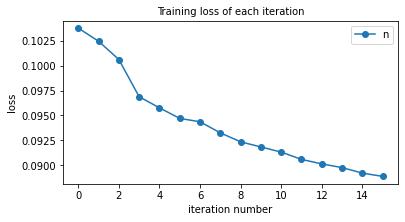

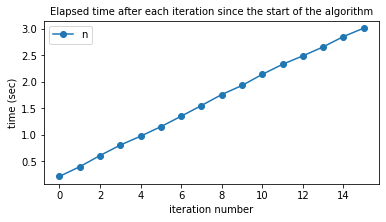

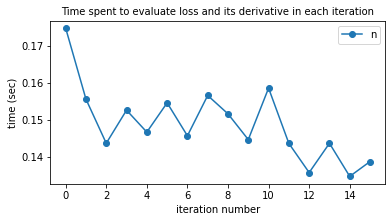

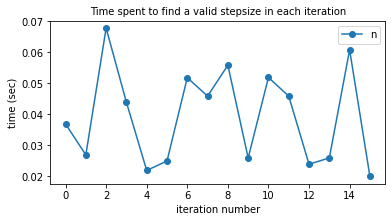

In [9]:
# Some informative figures to compare forced and flexible time complexity
plt.figure(figsize=(6,3))
plt.plot(forced_stats['train_losss'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.legend('neural network')
plt.title('Training loss of each iteration', fontsize=10)
plt.savefig('results/nn_trainlosss.png')

plt.figure(figsize=(6,3))
plt.plot(forced_stats['it_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.legend('neural network')
plt.title('Elapsed time after each iteration since the start of the algorithm', fontsize=10)
plt.savefig('results/nn_runtime.png')

plt.figure(figsize=(6,3))
plt.plot(forced_stats['eval_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.legend('neural network')
plt.title('Time spent to evaluate loss and its derivative in each iteration', fontsize=10)
plt.savefig('results/nn_evallosstimes.png')

plt.figure(figsize=(6,3))
plt.plot(forced_stats['stepsizeloop_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.legend('neural network')
plt.title('Time spent to find a valid stepsize in each iteration', fontsize=10)
plt.savefig('results/nn_stepsizetimes.png')

## Assess the neural network's accuracy and running time

In [10]:
# a utility function to use with the 'bn.assess' method
def get_nn_acc(train_data, val_data, nn_opt_params=nn_opt_params, nn_arch_params=nn_arch_params):
    """
    Fit neural network to the training images and measure accuracy on validation set.
    NOTE: nn_opt_params, nn_arch_params are used from outside of the function.
    """
    Theta, stats = bn.fit(train_data['des'], train_data['lbls'], \
                          nn_opt_params, nn_arch_params, show_nrmdE=False)

    val_acc, val_loss = bn.get_acc(val_data['des'], val_data['lbls'], nn_arch_params, Theta)
    
    return val_acc


In [11]:
nn_opt_params['print_checks'] = False
nn_portions = [0.02, 0.04, 0.06, 0.08, 0.10]
nn_rpts = [3]*len(nn_portions)

nn_nums, nn_accs, nn_times = bn.assess(get_slowfast_data, get_nn_acc, nn_portions, nn_rpts, show_msgs = True)

data size  iteration  train_num   val_num     acc(%)   dtime(ms)  rtime(ms) 
----------------------------------------------------------------------------
   0.02        0          17         4        100.0      11.96      42.89   
   0.02        1          17         4        100.0      6.979      42.89   
   0.02        2          17         4        100.0      7.017      44.84   
   0.02     Average      17.0       4.0       100.0      8.654      43.54   

   0.04        0          35         8        100.0      13.96      107.7   
   0.04        1          35         8        100.0      18.95      99.73   
   0.04        2          35         8        100.0      15.96      83.78   
   0.04     Average      35.0       8.0       100.0      16.29      97.07   

   0.06        0          53         13       100.0      25.93      142.6   
   0.06        1          53         13       100.0      27.92      152.6   
   0.06        2          53         13       92.31      27.93      162.6 

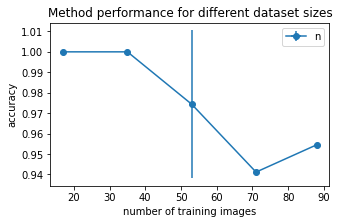

In [12]:
# plot accuracies obtained at different sizes
plt.figure(figsize=(5,3))
plt.errorbar(nn_nums['train_nums'], nn_accs['val'], nn_accs['std'], nn_nums['train_nums_std'], marker='o')
plt.xlabel('number of training images')
plt.ylabel('accuracy')
plt.legend('neural network')
plt.title('Method performance for different dataset sizes')
plt.savefig('results/nn_performance.png')

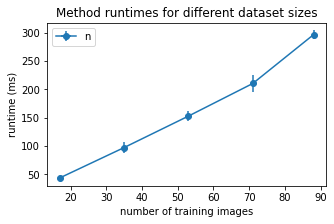

In [13]:
# plot model running times at different sizes
plt.figure(figsize=(5,3))
plt.errorbar(nn_nums['train_nums'], np.array(nn_times['run_t'])*1000, \
             np.array(nn_times['run_t_std'])*1000, nn_nums['train_nums_std'], marker='o')
plt.xlabel('number of training images')
plt.ylabel('runtime (ms)')
plt.legend('neural network')
plt.title('Method runtimes for different dataset sizes')
plt.savefig('results/nn_runtimes4sizes.png')

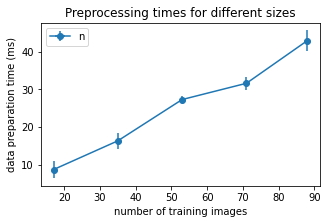

In [14]:
# plot data preparation times at different sizes
plt.figure(figsize=(5,3))
plt.errorbar(nn_nums['train_nums'], np.array(nn_times['data_t'])*1000, \
             np.array(nn_times['data_t_std'])*1000, nn_nums['train_nums_std'], marker='o')
plt.xlabel('number of training images')
plt.ylabel('data preparation time (ms)')
plt.legend('neural network')
plt.title('Preprocessing times for different sizes')
plt.savefig('results/nn_pretimes4sizes.png')

# Use the similiarity graph model on the data

In [15]:
# # get a smaller dataset because the larger one eats up too much RAM
# train_num_t, val_num_t, train_data_t, val_data_t = get_slowfast_data(portion=0.1, path='../../data/slowfast_4608/', fracs=[0.6,0.4], seed=1830)
# print('train_num = ', train_num_t, ', val_num = ', val_num_t)
# print('train_lbls = ', train_data_t['lbls'], '\nval_lbls = ', val_data_t['lbls'])
# print('train_smpls = ', train_data_t['smpls'], ', val_smpls = ', val_data_t['smpls'])

In [16]:
# learning phase
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.5, \
              'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
              'force_all_its': True, 'threshold': 0.01}

B, sg_stats = sg.fit_graph(train_data['des'], train_data['lbls'], sg_opt_params, D=10, seed=0)

entered sg.fit_graph. Here are the inputs:
dess
 [[0.0235625  0.04725317 0.0235625  ... 0.2546776  0.23644175 0.2577173 ]
 [0.0505811  0.0505811  0.0505811  ... 0.03023093 0.0281882  0.03029323]
 [0.05655165 0.04411096 0.05655165 ... 0.1181677  0.08457488 0.10017688]
 ...
 [0.04019119 0.08027563 0.04171545 ... 0.10630625 0.08166973 0.09255882]
 [0.04355367 0.06767221 0.04355367 ... 0.1647431  0.12500654 0.1390916 ]
 [0.11763558 0.12806548 0.11763558 ... 0.03807674 0.02987598 0.0311082 ]]
lbls
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

KeyboardInterrupt: 

In [16]:
# estimation phase
acc, y_est, t = sg.get_acc(B, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'])

print('val acc = ', acc)
print('estimated val labels = ', (y_est>0).astype(np.int32))

# save results
np.savetxt('results/sg_val_acc.txt', np.array([acc]))
np.savetxt('results/sg_y_est.csv', y_est, delimiter=',')

val acc =  0.9594594594594594
estimated val labels =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


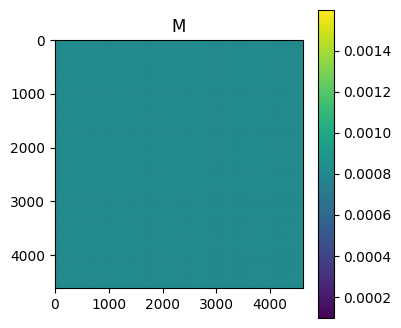

In [17]:
# display learned M
M = B.T @ B
# to preserve memory, uncomment below line
# del B

sg.display_matrix(M, 'M')

# save results
plt.savefig('results/sg_finalM.png')
np.savetxt('results/sg_finalB.csv', B, delimiter=',')

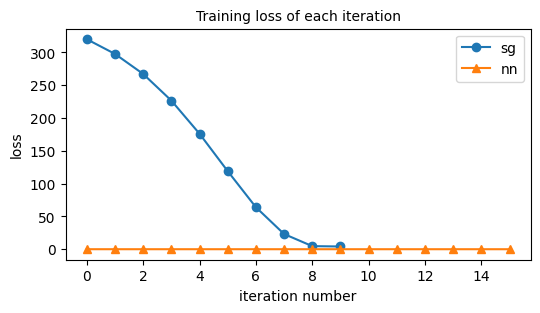

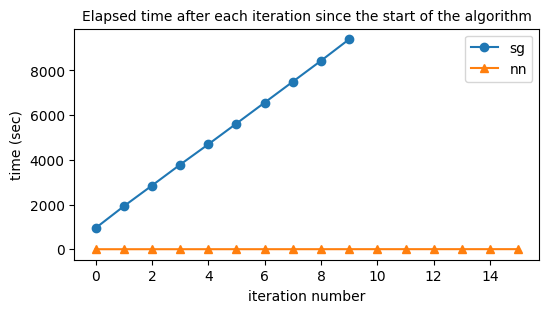

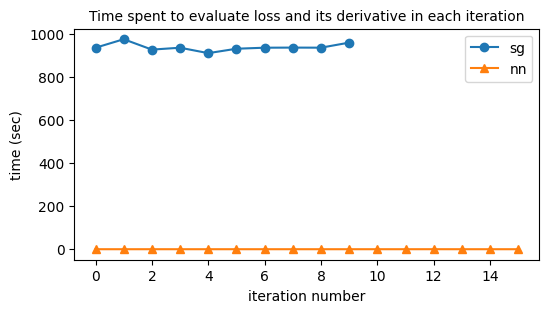

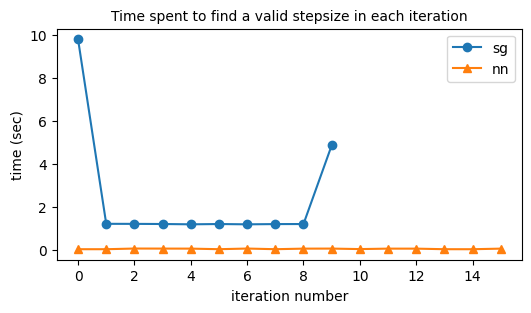

In [18]:
# Some informative figures to compare forced and flexible time complexity
plt.figure(figsize=(6,3))
plt.plot(sg_stats['train_losss'], marker='o')
plt.plot(forced_stats['train_losss'], marker='^')
plt.legend(['sg', 'nn'])
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.title('Training loss of each iteration', fontsize=10)
plt.savefig('results/sg_trainlosss.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['it_times'], marker='o')
plt.plot(forced_stats['it_times'], marker='^')
plt.legend(['sg', 'nn'])
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Elapsed time after each iteration since the start of the algorithm', fontsize=10)
plt.savefig('results/sg_runtime.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['eval_times'], marker='o')
plt.plot(forced_stats['eval_times'], marker='^')
plt.legend(['sg', 'nn'])
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Time spent to evaluate loss and its derivative in each iteration', fontsize=10)
plt.savefig('results/sg_evallosstime.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['stepsizeloop_times'], marker='o')
plt.plot(forced_stats['stepsizeloop_times'], marker='^')
plt.legend(['sg', 'nn'])
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Time spent to find a valid stepsize in each iteration', fontsize=10)
plt.savefig('results/sg_epsilontime.png')

(0.0008033950504377376, 4815600.0)

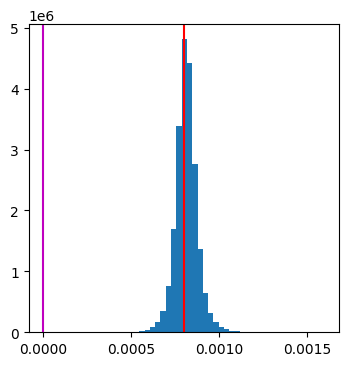

In [19]:
sg.hist_of_entries(M, 50, zeroline=True, peakline=True)
plt.title('Histogram of M entries')

## Assess the graph model's performance and running time

In [41]:
# utility function to use with 'bn.assess' method
def get_sg_acc(train_data, val_data, sg_opt_params=sg_opt_params, D=1):
    """
    Fit similarity graph to training data and measure accuracy on validation set.
    NOTE: sg_opt_params, D are used from outside of the function.
    """
    B, stats = sg.fit_graph(train_data['des'], train_data['lbls'], \
                                      sg_opt_params, D=D, seed = None)

    acc, y_est, t = sg.get_acc(B, train_data['des'], train_data['lbls'], \
                               val_data['des'], val_data['lbls'])
    
    return acc

In [43]:
sg_opt_params['print_checks'] = False
sg_portions = [0.02, 0.04, 0.06, 0.08, 0.10]
sg_rpts = [3]*len(sg_portions)

sg_nums, sg_accs, sg_times = bn.assess(get_slowfast_data, get_sg_acc, sg_portions, sg_rpts, show_msgs = True)

data size  iteration  train_num   val_num     acc(%)   dtime(ms)  rtime(ms) 
----------------------------------------------------------------------------


KeyboardInterrupt: 

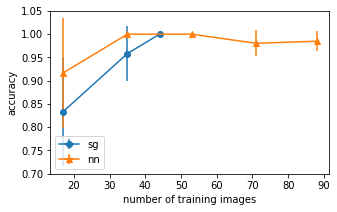

In [34]:
# plot accuracies obtained at different sizes
plt.figure(figsize=(5,3))
plt.errorbar(sg_nums['train_nums'], sg_accs['val'], sg_accs['std'], sg_nums['train_nums_std'], marker='o')
plt.errorbar(nn_nums['train_nums'], nn_accs['val'], nn_accs['std'], nn_nums['train_nums_std'], marker='^')
plt.xlabel('number of training images')
plt.ylabel('accuracy')
plt.legend(['sg', 'nn'])
plt.title('Method performance for different dataset sizes')
plt.savefig('results/sg_performance.png')

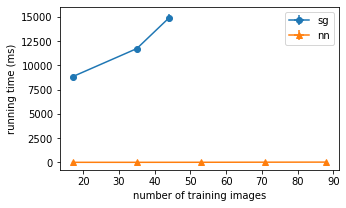

In [35]:
# plot model running times at different sizes
plt.figure(figsize=(5,3))
plt.errorbar(sg_nums['train_nums'], np.array(sg_times['run_t'])*1000, \
             np.array(sg_times['run_t_std'])*1000, sg_nums['train_nums_std'], marker='o')
plt.errorbar(nn_nums['train_nums'], np.array(nn_times['run_t'])*1000, \
             np.array(nn_times['run_t_std'])*1000, nn_nums['train_nums_std'], marker='^')
plt.xlabel('number of training images')
plt.ylabel('running time (ms)')
plt.legend(['sg', 'nn'])
plt.title('Method runtimes for different dataset sizes')
plt.savefig('results/sg_runtimes.png')

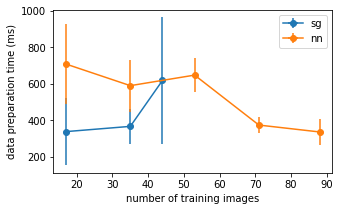

In [36]:
# plot data preparation times at different sizes
plt.figure(figsize=(5,3))
plt.errorbar(sg_nums['train_nums'], np.array(sg_times['data_t'])*1000, \
             np.array(sg_times['data_t_std'])*1000, sg_nums['train_nums_std'], marker='o')
plt.errorbar(nn_nums['train_nums'], np.array(nn_times['data_t'])*1000, \
             np.array(nn_times['data_t_std'])*1000, nn_nums['train_nums_std'], marker='o')
plt.xlabel('number of training images')
plt.ylabel('data preparation time (ms)')
plt.legend(['sg', 'nn'])
plt.title('Method preprocessing times for different sizes')
plt.savefig('results/sg_pretimes4sizes.png')